# Default settings

In [1]:
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(10,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Class for "Pythonizing" Data

In [3]:
import numpy as np
from root_numpy import root2array
import os
import subprocess
from collections import OrderedDict

class CTHHits(object):
    # pylint: disable=too-many-instance-attributes
    # pylint: disable=bad-continuation
    def __init__(self, path="../data/151208_SimChen_noise.root", treename='tree',
            branches=["M_t","M_edep","M_hittype"]):
        """
        Dataset provides an interface to work with MC stored in root format.
        Results of methods are either numpy.arrays or scipy.sparse objects.

        :param path: path to rootfile
        :param treename: name of the tree in root dataset
        """
        # Hardcode the volume names
        self.volume_names = ['TriSciD', 'TriCheD', 'TriCheLD',
                             'TriSciU', 'TriCheU', 'TriCheLU']
        # Initialize volume ID lookup table
        self.names_to_flatIDs, self.flatIDs_to_names = self._get_names_flatIDs_lookups()

        # Initialize our data and look up tables
        self.hits_to_events, self.event_to_hits, self.event_to_n_hits =\
            self._get_event_to_hits_lookup(path, treename=treename)
        
        # Set the number of hits and events for this data        
        self.n_hits = len(self.hits_to_events)
        self.n_events = len(self.event_to_n_hits)
            
        # Get the geometry flat_IDs
        geom_name, geom_row = self._get_geom_flat_ids(path, treename=treename)

        # Get the hit data we want
        data_names, data_rows = self._get_data(path, treename=treename, branches=branches)
        
        # Label each hit with the number of hits in its event
        self.all_nHits_name = "M_nHits"
        all_nHits_row = [self.event_to_n_hits[self.hits_to_events]]
        
        # Index each hit
        self.hits_index_name = "hits_index"
        hits_index_row = [np.arange(self.n_hits)]
        
        # Zip it all together in a record array
        all_names = geom_name + data_names + [self.all_nHits_name] + [self.hits_index_name]
        all_rows = geom_row + data_rows + all_nHits_row + hits_index_row
        self.hits_data = np.rec.fromarrays(all_rows, names=(all_names))
        
        # Sort the data by time by default if it is included
        if "M_t" in branches:
            self.sort_hits("M_t")
        
        
    def _get_names_flatIDs_lookups(self):
        """
        Creates a lookup table to map from [volName][volID] to a flattened
        volume name and ID, and from flattened ID to (volName, volID)
        
        Total: 384 "channels" for trigger
        
        Downsteam          Flat_Id      VolName     VolID   
           Scintillator    0   - 63     TriSciD     0 - 63
           Cherenkov       64  - 127    TriCheD     0 - 63
           Cherenkov LG    128 - 191    TriCheLD    0 - 63
        Upstream          
           Scintillator    191 - 255    TriSciU     0 - 63
           Cherenkov       256 - 319    TriCheU     0 - 63
           Cherenkov LG    320 - 383    TriCheLU    0 - 63
        """
        # Initialize the flattened IDs
        flat_ids = [np.arange(n*64,(n+1)*64) for n in range(len(self.volume_names))]
        # Create the lookup table for names, volID to flattened ID
        names_to_flat = np.rec.fromarrays(flat_ids, names=(self.volume_names))
        # Initialize the lookup table for flattened ID to (volName, volID)
        flat_to_names = []
        for name in self.volume_names:
            for volID in range(64):
                flat_to_names.append((name, int(volID)))
        return names_to_flat, flat_to_names
        
    def _get_event_to_hits_lookup(self, path, treename):
        """
        Creates look up tables to map from events to hits index and from 
        hit to event number
        """
        # Name the branch that gives the number of hits
        nHits_branch = "M_nHits"
        # Import the data
        event_data = root2array(path, treename=treename,\
                                branches=[nHits_branch])
        # Initialize a look up table that maps from hit number to event number
        hits_to_events = np.zeros(sum(event_data[nHits_branch]))
        # Create a look up table that maps from event number the range of hits IDs
        # in that event
        event_to_hits = []
        # Store the number of hits in each event
        event_to_n_hits = event_data[nHits_branch].copy().astype(int)
        # Build the look up tables
        first_hit = 0
        for event in range(len(event_data)):
            # Record the last hit in the event
            last_hit = first_hit + event_to_n_hits[event]
            # Record the range of hit IDs
            event_to_hits.append(np.arange(first_hit,last_hit))
            # Record the event of each hit
            hits_to_events[first_hit:last_hit] = event
            # Shift to the next event
            first_hit = last_hit
        # Shift the event-to-hit list into a numpy object array
        event_to_hits = np.array(event_to_hits)
        # Ensure all indexes in hits to events are integers
        hits_to_events = hits_to_events.astype(int)
       
        # Return the lookup tables 
        return hits_to_events, event_to_hits, event_to_n_hits

    def _get_geom_flat_ids(self, path, treename, flatID_name="flat_volID"):
        """
        Labels each hit by flattened geometry ID to replace the use of volName and
        volID
        """
        # Variables that index the geometry
        geom_var = ["M_volName", "M_volID"]
        # Import the data
        event_data = root2array(path, treename=treename,\
                                branches=geom_var)
       
        # Flatten the volume names and IDs to flat_voldIDs
        # Create a dictionary to map from name to lower flatID
        names_to_lowers = dict(zip(self.volume_names, np.arange(6)*64))
        # Assign the flatIDs for each hit
        flat_ids = np.zeros(self.n_hits)
        for name, vol_id, hit in zip(np.concatenate(event_data[geom_var[0]]),\
                                     np.concatenate(event_data[geom_var[1]]),\
                                     range(self.n_hits)):
            flat_ids[hit] = names_to_lowers[name] + vol_id
        # Save this column and name it
        flatID_row = flat_ids.astype(int)
     
        # Return 
        return [flatID_name], [flatID_row]
        
    def _get_data(self, path, treename, branches):
        """
        Flattens the needed hit data into rows, one row for each variable
        """
        # Import the data
        event_data = root2array(path, treename=treename,\
                                branches=branches)

        # Flatten each variable into a row of all hits and name the rows
        data_rows = []
        for hit_var in branches:
            data_rows.append(np.concatenate(event_data[hit_var]))
    
        # Return 
        return branches, data_rows
    
    def sort_hits(self, variable, ascending=True, reset_index=True):
        """
        Sorts the hits by the given variable inside each event.  By default, 
        this is done in acending order and the hit index is reset after sorting.
        """
        # Sort each event internally
        for evt in range(self.n_events):
            # Get the hits to sort
            evt_hits = self.event_to_hits[evt]
            # Get the sort order of the given variable
            sort_order = self.hits_data[evt_hits][variable].argsort()
            # Reverse the order if required
            if ascending == False:
                sort_order = sort_order[::-1]
            # Rearrange the hits
            self.hits_data[evt_hits] = self.hits_data[evt_hits][sort_order]
        # Reset the hit index
        if reset_index == True:
            self.hits_data[self.hits_index_name] = np.arange(self.n_hits)
        
    def get_events(self, events=None, unique=True):
        """
        Returns the hits from the given event(s).  Default gets all events
        
        :param unique: Force each event to only be retrieved once
        """
        # Check if we want all events
        if events is None:
            return self.hits_data
        # Allow for a single event
        if isinstance(events, int):
            evt_hits = self.event_to_hits[events]
        # Otherwise assume it is a list of events.
        else: 
            # Ensure we only get each event once
            if unique: 
                events = np.unique(events)
            # Get all the hits we want as flat
            evt_hits = np.concatenate([self.event_to_hits[evt] for evt in events])
        # Return the data for these events
        return self.hits_data[evt_hits]

    def _filter_hits(self, selected_hits, variable, values):
        """
        Returns the section of the data where the variable equals 
        any of the values
        """
        mask = np.in1d(selected_hits[variable], values)
        return selected_hits[mask]
    
    def get_other_hits(self, hits):
        """
        Returns the hits from the same event(s) as the given hit list
        """
        events = self.hits_to_events[hits]
        events = np.unique(events)
        return self.get_events(events)
    
    def get_signal_hits(self, events=None):
        """
        Returns the hits from the same event(s) as the given hit list.
        Default gets hits from all events.
        """
        these_hits = self.get_events(events)
        these_hits = self._filter_hits(these_hits, "M_hittype", [1,2])
        return these_hits

    def get_background_hits(self, events=None):
        """
        Returns the hits from the same event(s) as the given hit list
        Default gets hits from all events.
        """
        these_hits = self.get_events(events)
        these_hits = self._filter_hits(these_hits, "M_hittype", [-2,-1,0])
        return these_hits

    def get_hits_by_volume(self, events=None, flat_volIDs=None, 
                           volNames=None, volIDs=None, 
                           signal_only=False, background_only=False):
        """
        Returns the hits of a given volume using the flat ID.  These are defined as:
        Total: 384 "channels" for trigger
        
        Downsteam          Flat_Id      VolName     VolID   
           Scintillator    0   - 63     TriSciD     0 - 63
           Cherenkov       64  - 127    TriCheD     0 - 63
           Cherenkov LG    128 - 191    TriCheLD    0 - 63
        Upstream          
           Scintillator    191 - 255    TriSciU     0 - 63
           Cherenkov       256 - 319    TriCheU     0 - 63
           Cherenkov LG    320 - 383    TriCheLU    0 - 63
        
        If the flat volIDs are set, these take precident over volName and volID.
        """
        # Get the events we want
        if (signal_only == True) and (background_only == True): 
            these_hits = self.get_events(events)
        elif signal_only == True:
            these_hits = self.get_signal_hits(events)
        elif background_only == True:
            these_hits = self.get_background_hits(events)
        else: 
            these_hits = self.get_events(events)
        # Flat Volume IDs comes first
        if (volNames is not None) and (volIDs is not None):
            flat_volIDs = []
            for name in volNames:
                flat_volIDs.append(self.names_to_flatIDs[name][volIDs]) 
        return self._filter_hits(these_hits, "flat_volID", flat_volIDs)

## Get the hits

In [4]:
these_hits = CTHHits("../data/151208_SimChen_signal.root")

In [5]:
# Quick and dirty volume grabbing
all_flat_volIDs = [range(0,64), range(64,128), range(128, 191),\
                   range(191, 255), range(255, 319), range(320, 384)] 
titles = ["Upstream Scintillator Hits", "Upstream Cherenkov Hits", "Upstream Cherenkov Light Guide Hits",\
          "Downstream Scintillator Hits", "Downstream Cherenkov Hits", "Downstream Cherenkov Light Guide Hits"]

Number of Signal Hits : 1539
Number of Background Hits : 1146795


/home/elg112/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


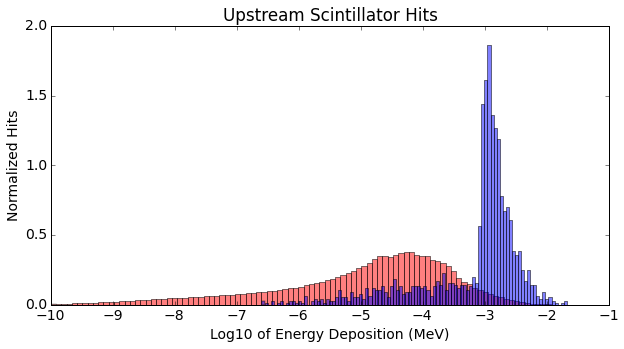

Number of Signal Hits : 2122
Number of Background Hits : 1851481


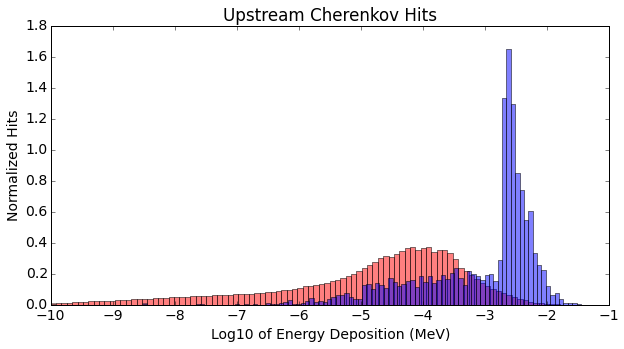

Number of Signal Hits : 1143
Number of Background Hits : 1395239


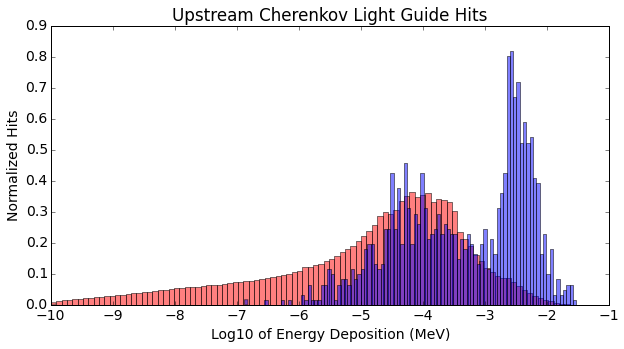

Number of Signal Hits : 1290
Number of Background Hits : 1589436


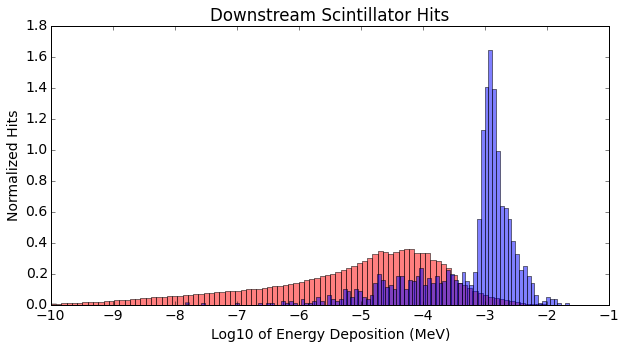

Number of Signal Hits : 1923
Number of Background Hits : 2532175


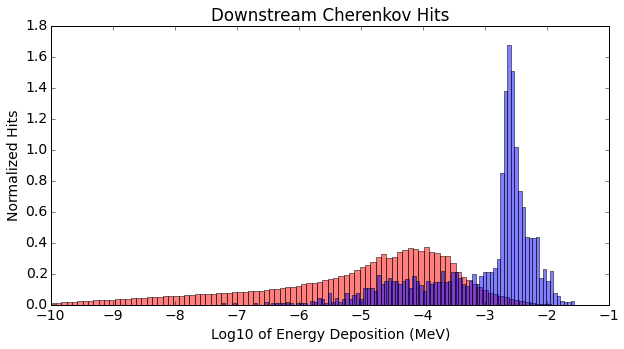

Number of Signal Hits : 580
Number of Background Hits : 1270968


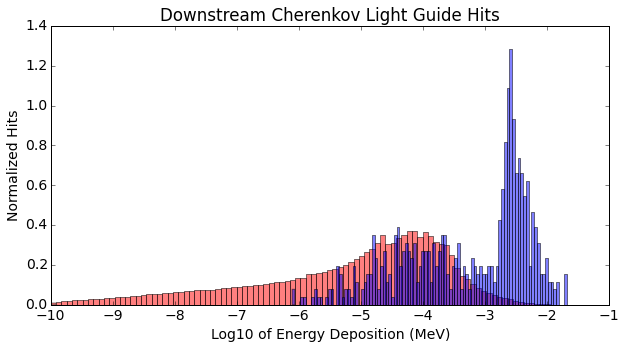

In [6]:
for this_flat_volIDs, title in zip(all_flat_volIDs, titles):
    sig_hits = these_hits.get_hits_by_volume(flat_volIDs = this_flat_volIDs, signal_only = True)
    bkg_hits = these_hits.get_hits_by_volume(flat_volIDs = this_flat_volIDs, background_only = True)
    
    print "Number of Signal Hits : {}".format(len(sig_hits))
    print "Number of Background Hits : {}".format(len(bkg_hits))
    plt.hist(np.log10(bkg_hits["M_edep"] + 0.0000000001), bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(np.log10(sig_hits["M_edep"] + 0.0000000001), bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(title)
    plt.xlabel("Log10 of Energy Deposition (MeV)")
    plt.ylabel("Normalized Hits")
    plt.show()

Number of Signal Hits : 1539
Number of Background Hits : 1146795


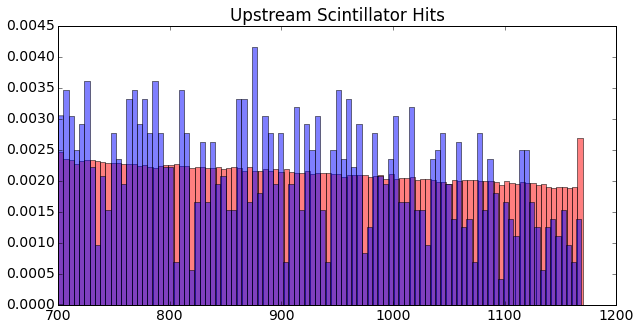

Number of Signal Hits : 2122
Number of Background Hits : 1851481


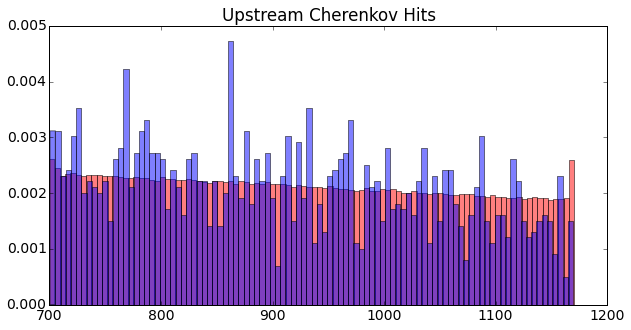

Number of Signal Hits : 1143
Number of Background Hits : 1395239


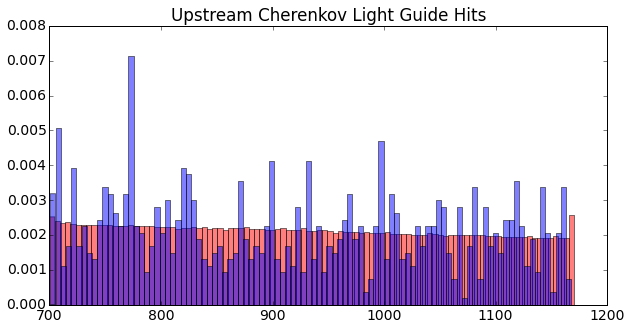

Number of Signal Hits : 1290
Number of Background Hits : 1589436


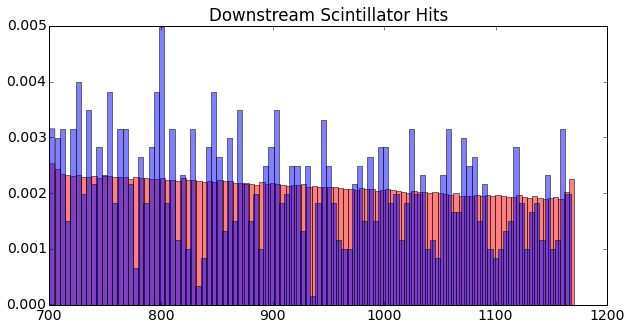

Number of Signal Hits : 1923
Number of Background Hits : 2532175


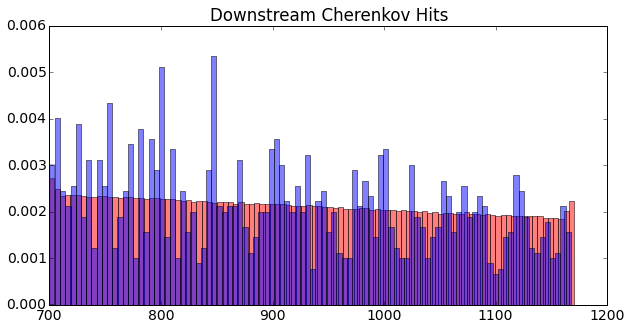

Number of Signal Hits : 580
Number of Background Hits : 1270968


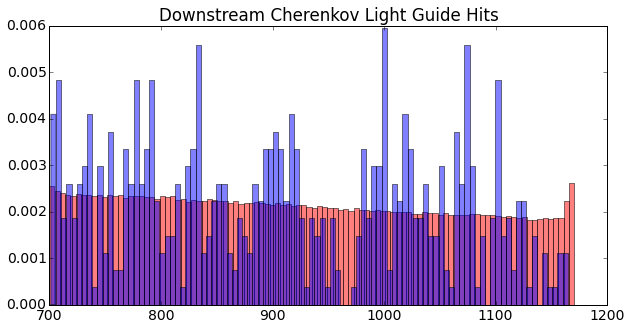

In [7]:
for this_flat_volIDs, title in zip(all_flat_volIDs, titles):
    sig_hits = these_hits.get_hits_by_volume(flat_volIDs = this_flat_volIDs, signal_only = True)
    bkg_hits = these_hits.get_hits_by_volume(flat_volIDs = this_flat_volIDs, background_only = True)
    
    print "Number of Signal Hits : {}".format(len(sig_hits))
    print "Number of Background Hits : {}".format(len(bkg_hits))
    plt.hist(bkg_hits["M_t"], bins=100, normed=True, color='red', alpha=0.5)
    plt.hist(sig_hits["M_t"], bins=100, normed=True, color='blue', alpha=0.5)
    plt.title(title)
    #plt.xlabel("Log10 of Energy Deposition (MeV)")
    #plt.ylabel("Normalized Hits")
    plt.show()